In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from kafka import KafkaConsumer, KafkaProducer
import json
import uuid
import pandas as pd
import numpy as np
import csv
import time
import datetime
import time
import matplotlib.pyplot as plt

In [2]:
server1 = 'broker1:9093'
server2 = 'broker2:9095'
server3 = 'broker3:9097'

topic_perf = "performance"

In [3]:
consumer_perf = KafkaConsumer(topic_perf,
                         auto_offset_reset='earliest',
                         bootstrap_servers=[server2],
                         api_version=(0, 10),
                         value_deserializer = json.loads,
                         #consumer_timeout_ms=50,
                         client_id="performance")


def clean_dataframe(df):
    df = df.set_index('time', drop=True)
    df.index = pd.to_datetime(df.index)
    df.mess_num = df.mess_num.astype(int)

    # resample data and take only full second measurement
    df = df.resample('s').sum()
    return df

def make_plot1(data):
    # clean data, get only full measurements seconds
    data_clean = clean_dataframe(data)[1:-1]

    fig, ax = plt.subplots(figsize=(12, 6))

    plt.plot(data_clean.index, data_clean.mess_num)
    #plt.ylim(0, 2000)
    plt.title("Anzahl verschickter Nachrichten, aggregiert: sekunde")
    plt.xlabel('Zeit')
    plt.ylabel('Anzahl Nachrichten/s')
    plt.xticks(rotation=45)
    plt.show()

def consume_perf(consumer, topic_name, timeout=10):
    # get data from Kafka
    df_data = pd.DataFrame(columns=['time', 'host', 'mess_num'])

    timeout_start = time.time()
    for i, msg in enumerate(consumer):

        #print(f'{datetime.datetime.now()}: messages received on topic: {topic_name}')
        #print(f'{msg.value}')

        # prepare data
        df_data = df_data.append(msg.value, ignore_index=True)

        time_diff = int(time.time() - timeout_start)
        if time_diff > timeout:
            print(f'timeout: {timeout}')
            return df_data


total messages: 186126


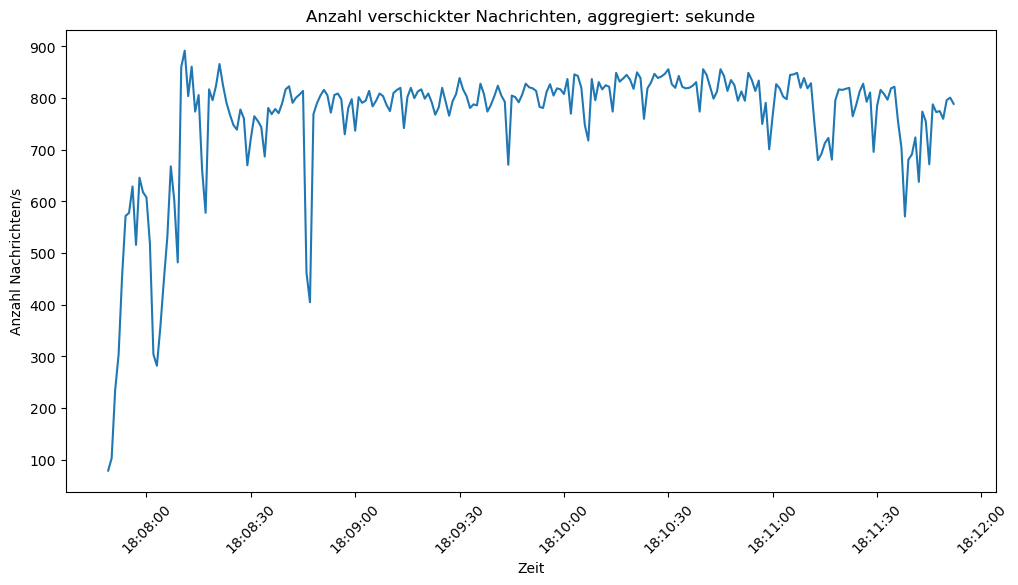


KeyboardInterrupt



In [4]:
from IPython.display import clear_output

df_data_all = pd.DataFrame(columns=['time', 'host', 'mess_num'])

#for i in range(20):
while True:
    data = consume_perf(consumer_perf, topic_perf, timeout=5)
    df_data_all = pd.concat([df_data_all, data])

    # show data
    clear_output(wait=True)
    print(f'total messages: {df_data_all.shape[0]}')
    make_plot1(df_data_all)